# TASK 1 - Acquire, preprocess, and analyze the data


### 1.1 Load Dataset

In [1]:
#Task1
import pandas as pd
import requests
import io
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from matplotlib import pylab as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


# download and load dataset1
url="https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv"
data=requests.get(url).content
df2=pd.read_csv(io.StringIO(data.decode('utf-8')))


#download and load dataset2
url1="https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv"
data1=requests.get(url1).content
df1=pd.read_csv(io.StringIO(data1.decode('utf-8')))



/Users/winnietam/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### 1.2 Data cleaning (searching data & hospital data)

In [2]:
# if the number of valid values in a column is <= threshold, drop that column
def columnClean (df1, threshold):
    before = len(df1.columns)
    cols_with_missing = [col for col in df1.columns if len(df1.loc[df1[col].notnull()]) <= threshold]
    df1=df1.drop(cols_with_missing, axis=1)
    print ("Number of features:\n before:",before, "| after cleaning:",len(df1.columns))
    return df1

# some of the symptoms have 0 valid entries (should be dropped)
print("(Searching Trends Dataset)")
df1=columnClean(df1, 0)

# Drop the columns with 0 non-null values
print("\n(COVID hospitalization cases dataset)")
df2=columnClean(df2, 0)
# Drop rows with too many missing entries

(Searching Trends Dataset)
Number of features:
 before: 430 | after cleaning: 127

(COVID hospitalization cases dataset)
Number of features:
 before: 62 | after cleaning: 61


In [3]:
# filter out all the US data since all the data in df1 are from US
df2_us=df2.loc[df2.open_covid_region_code.str.contains("US-")]

#Filter out all the valid open_covid_region_code in df1
regionCode=df1.open_covid_region_code.unique()
df2_us=df2_us.loc[df2_us.open_covid_region_code.map( lambda p: p in regionCode)==True]

#Since some of the columns contains 0 non-null, we will drop them
df2_us=columnClean(df2_us,0)

df2_us

Number of features:
 before: 61 | after cleaning: 5


,open_covid_region_code,region_name,date,hospitalized_cumulative,hospitalized_new
83900,US-WY,Wyoming,2020-03-07,0.0,0.0
83901,US-WY,Wyoming,2020-03-08,0.0,0.0
83902,US-WY,Wyoming,2020-03-09,0.0,0.0
83903,US-WY,Wyoming,2020-03-10,0.0,0.0
83904,US-WY,Wyoming,2020-03-11,0.0,0.0
...,...,...,...,...,...
96716,US-AK,Alaska,2020-10-14,0.0,0.0
96717,US-AK,Alaska,2020-10-15,0.0,0.0
96718,US-AK,Alaska,2020-10-16,0.0,0.0
96719,US-AK,Alaska,2020-10-17,0.0,0.0


In [4]:
# Data cleaning before merging
dateList=df1.date.unique()
def weeklyData (row):
    if row.date<=dateList.min():
        return dateList[0]
    if row.date >=dateList.max():
        return  'NA'
    dateList.sort()
    for i in range(1,len(dateList)):
        if row.date<=dateList[i] and row.date>=dateList[i-1]:
            return dateList[i]

df2_us['week']=df2_us.apply(weeklyData,axis='columns') # change days -> weeks

# df2_us['date'] = pd.to_datetime(df2_us['date'], format='%Y-%m-%d') # convert date to datetime obj
# df2_us['week'] = df2_us['date'].dt.week # extract week from datetime obj

group=df2_us.groupby(['week','open_covid_region_code'], as_index=False).hospitalized_new.sum()

df2_us=df2_us.loc[df2_us.week==df2_us.date]
df2_us=df2_us.drop(['hospitalized_new'],axis=1)
df2_us=pd.merge(df2_us,group,how='left',on=['open_covid_region_code','week'])
df2_us=df2_us.drop(['week'],axis=1)

df2_us

,open_covid_region_code,region_name,date,hospitalized_cumulative,hospitalized_new
0,US-WY,Wyoming,2020-03-09,0.0,0.0
1,US-WY,Wyoming,2020-03-16,0.0,0.0
2,US-WY,Wyoming,2020-03-23,0.0,0.0
3,US-WY,Wyoming,2020-03-30,17.0,17.0
4,US-WY,Wyoming,2020-04-06,23.0,6.0
...,...,...,...,...,...
476,US-AK,Alaska,2020-08-31,0.0,0.0
477,US-AK,Alaska,2020-09-07,0.0,0.0
478,US-AK,Alaska,2020-09-14,0.0,0.0
479,US-AK,Alaska,2020-09-21,0.0,0.0


### 1.3 Merge 2 datasets and normalize

In [5]:
from sklearn.preprocessing import StandardScaler


# merge 2 dataset
df = pd.merge(df1,df2_us,how='left',on=['open_covid_region_code','date'])

# copy the df dataset for task3
df_ml = df.copy()
df_ml.drop_duplicates(inplace=True)
df_ml

# normalize by region
regions = df_ml['open_covid_region_code'].unique()

# df_ml = df_ml.fillna(0)

dfs_list = []

for region in regions:
  df_region = df_ml[df_ml['open_covid_region_code'] == region]
  region_labels1 = df_region.iloc[:,0:6] # Region, date, etc.
  region_labels2 = df_region.iloc[:,127:] # Hospitalization data

  region_features = df_region.iloc[:,6:127]
  scaled_features = StandardScaler().fit_transform(region_features.values)
  scaled_df = pd.DataFrame(scaled_features, index=region_features.index, columns=region_features.columns)
  df_region = pd.concat([region_labels1, scaled_df, region_labels2], axis=1) # concatenate HORIZONTALLY
  dfs_list.append(df_region)
  
df_ml = pd.concat(dfs_list) # concatenate VERTICALLY
df_ml
  

#df = df.drop(['region_name', 'country_region_code', 'country_region', 'open_covid_region_code'], axis=1) # remove duplicate columns
# df.dropna(axis=0, subset=['hospitalized_cumulative', 'hospitalized_new'], inplace=True) # drop rows with no hospitalization data
# df.iloc[:, 3:-2] = df.iloc[:, 3:-2].fillna(0) # fill NaN's in the symptoms with 0
# df = df.reset_index(drop=True)

/Users/winnietam/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/winnietam/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/winnietam/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/winnietam/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/winnietam/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/winnietam/opt/anaconda3/

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amblyopia,...,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Yawn,region_name,hospitalized_cumulative,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,0.474441,NaN,NaN,NaN,...,0.227741,0.762673,NaN,1.119545,0.605730,NaN,0.040066,NaN,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,-0.363814,NaN,NaN,NaN,...,0.076600,0.393740,0.489135,1.602045,-0.155525,NaN,0.795595,NaN,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,NaN,...,0.194655,0.024808,0.339936,-0.375413,3.792853,NaN,1.261122,NaN,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,1.176112,-0.865236,NaN,NaN,...,0.345797,2.293532,NaN,0.020079,NaN,NaN,-1.238228,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,-0.564674,NaN,NaN,NaN,...,0.361588,2.030614,NaN,1.182824,0.996508,-0.172280,1.814414,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,US-WY,US,United States,Wyoming,US-WY,2020-09-07,-0.438104,-0.420914,-1.489151,-1.141587,...,-0.625928,-0.756729,NaN,0.034471,NaN,NaN,-0.358864,Wyoming,219.0,4.0
636,US-WY,US,United States,Wyoming,US-WY,2020-09-14,-0.226613,1.179446,NaN,0.515511,...,-0.327778,-0.708082,-0.343062,-0.689416,NaN,NaN,-0.004414,Wyoming,230.0,11.0
637,US-WY,US,United States,Wyoming,US-WY,2020-09-21,0.172275,-0.030129,NaN,0.636227,...,-0.617409,-1.226982,NaN,0.758357,0.715628,NaN,0.390544,Wyoming,247.0,17.0
638,US-WY,US,United States,Wyoming,US-WY,2020-09-28,1.283272,0.779356,NaN,-0.033197,...,NaN,-0.545926,NaN,1.585656,0.999945,NaN,1.565291,Wyoming,264.0,17.0


# TASK 2 - Visualize and cluster the data
Your next task is to leverage dimensionality reduction techniques and visualize the data. The subtasks for this part include:
1. Visualize the evolution of popularity of various symptoms across different regions over time. Specifically, you need to visualize how the distribution of search frequency of each symptom aggregated across different regions changes over time. You can only do these plots for some of the most popular symptoms only. Hint: checkout some visualizations here for inspiration.
2. Visualize the search trends dataset in a lower dimensional space. Use Principal Component Analysis (PCA) to reduce the data dimensionality. Hint: You may treat each time point as an independent data point.
3. Explore using a clustering method – e.g., k-means – to evaluate possible groups in the search trends dataset. Do the clusters remain consistent for raw as well as PCA-reduced data?

## 2.1 Visualizations of top symptoms distribution by regions

Number of features:
 before: 130 | after cleaning: 18
['open_covid_region_code' 'country_region_code' 'country_region'
 'sub_region_1' 'sub_region_1_code' 'date' 'symptom:Angular cheilitis'
 'symptom:Aphonia' 'symptom:Crackles' 'symptom:Dysautonomia'
 'symptom:Hemolysis' 'symptom:Laryngitis' 'symptom:Rectal pain'
 'symptom:Shallow breathing' 'symptom:Ventricular fibrillation'
 'region_name' 'hospitalized_cumulative' 'hospitalized_new']


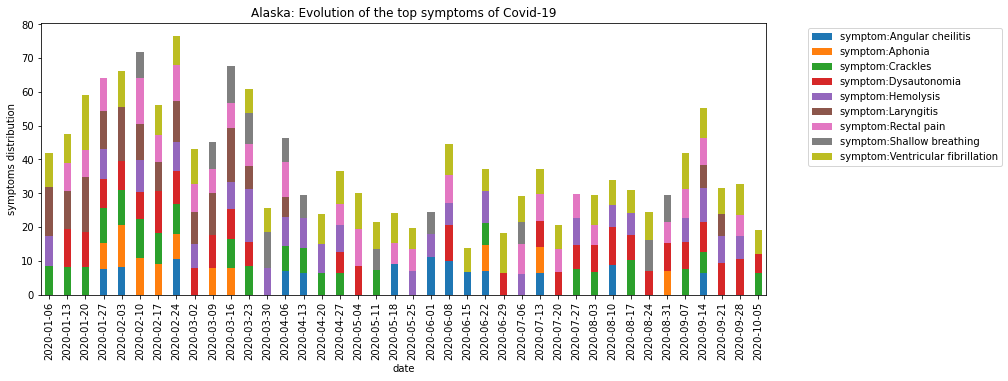

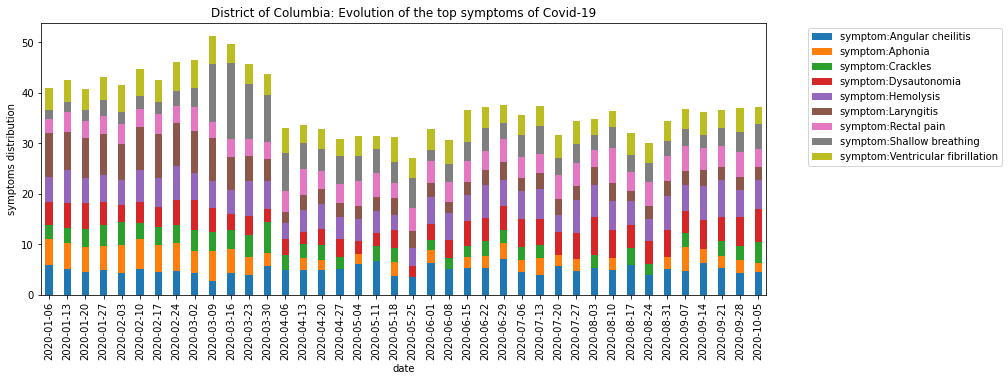

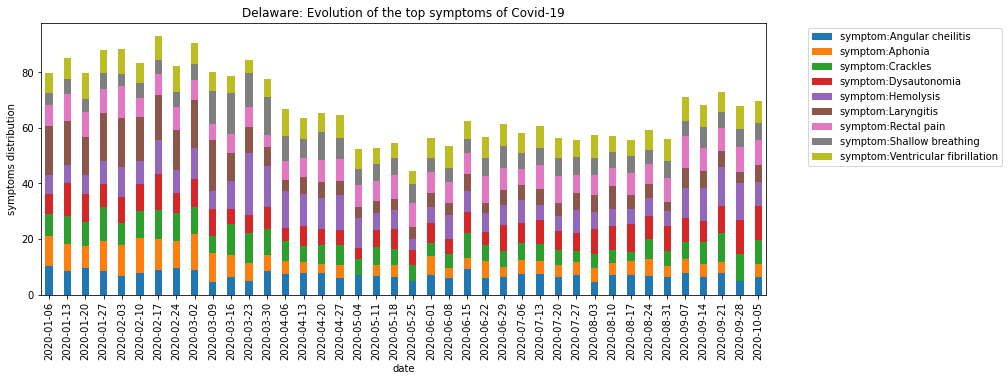

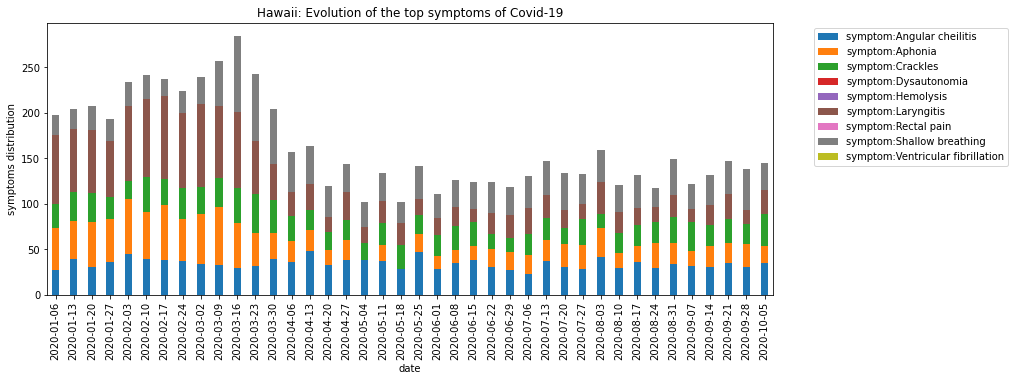

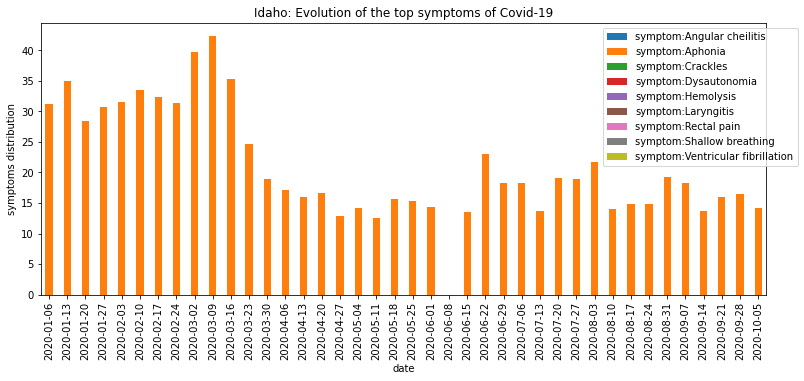

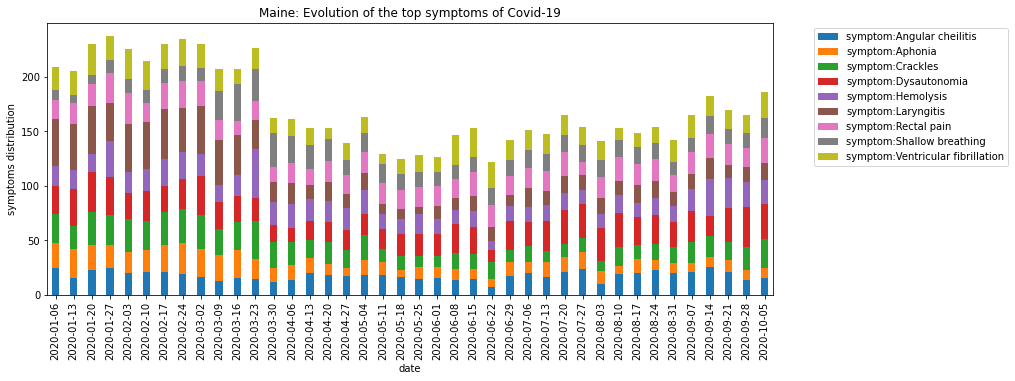

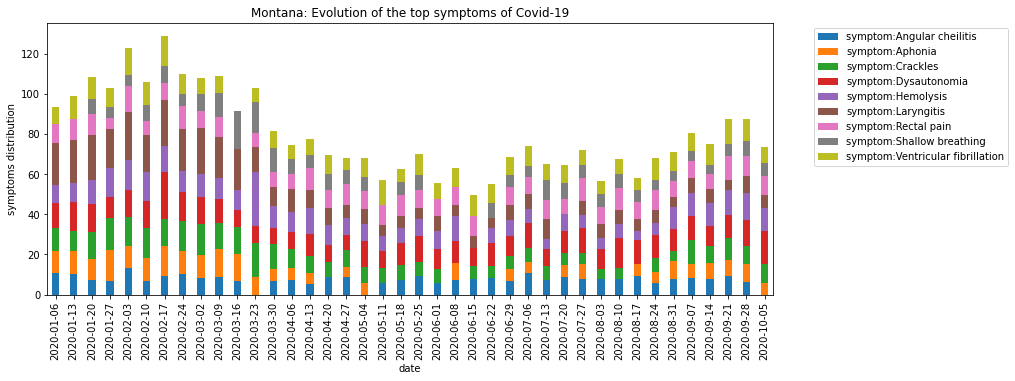

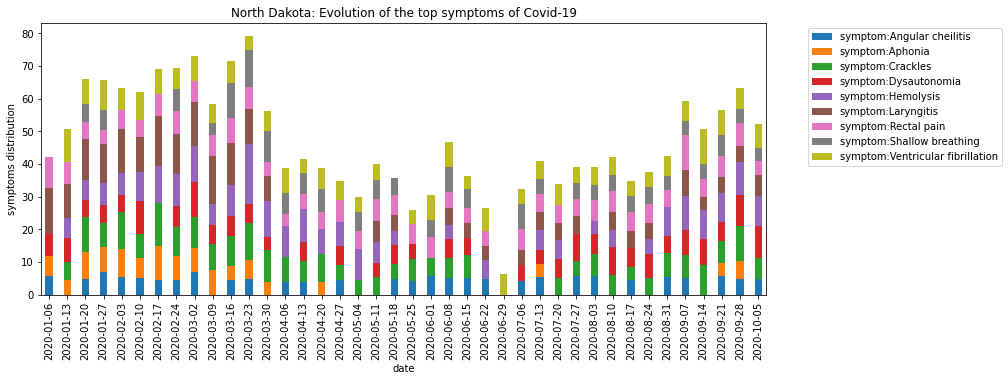

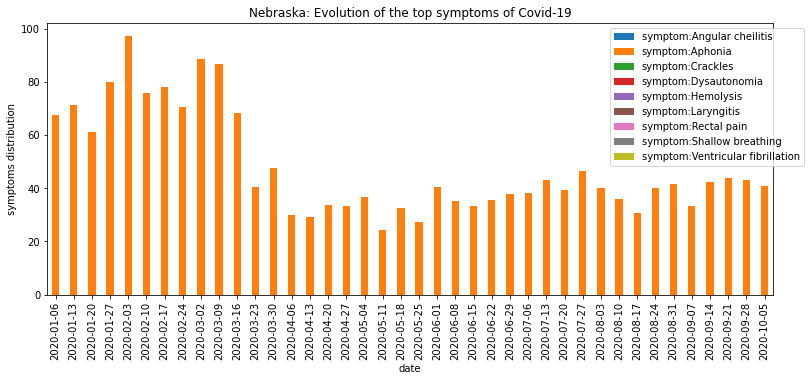

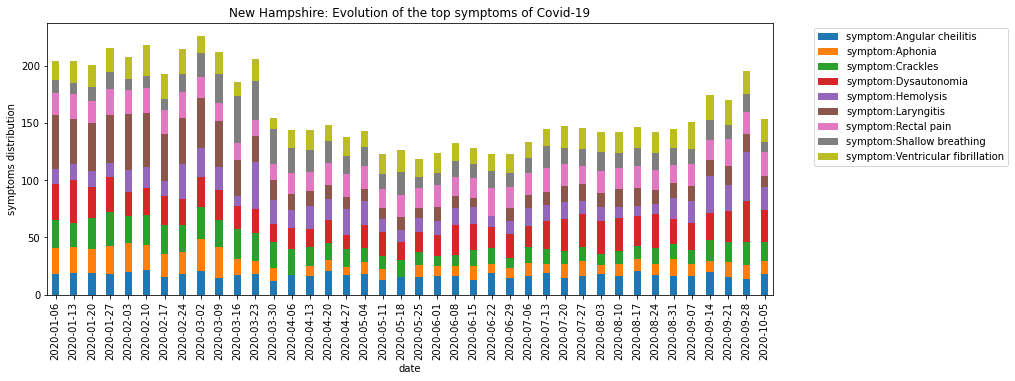

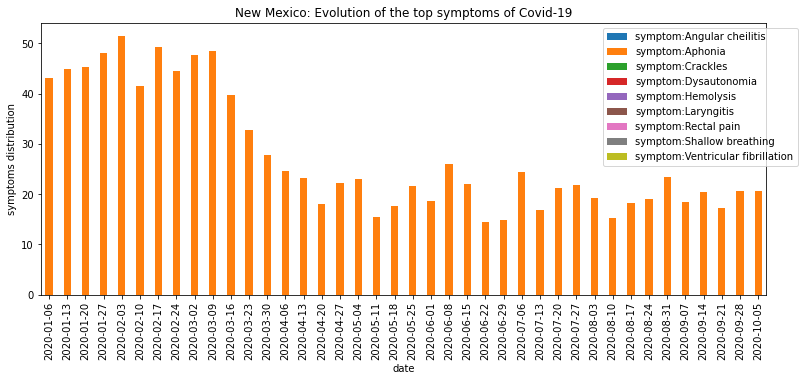

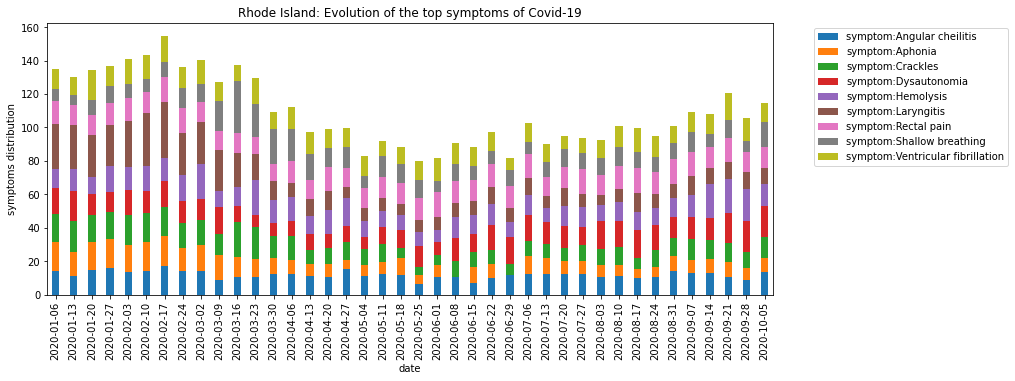

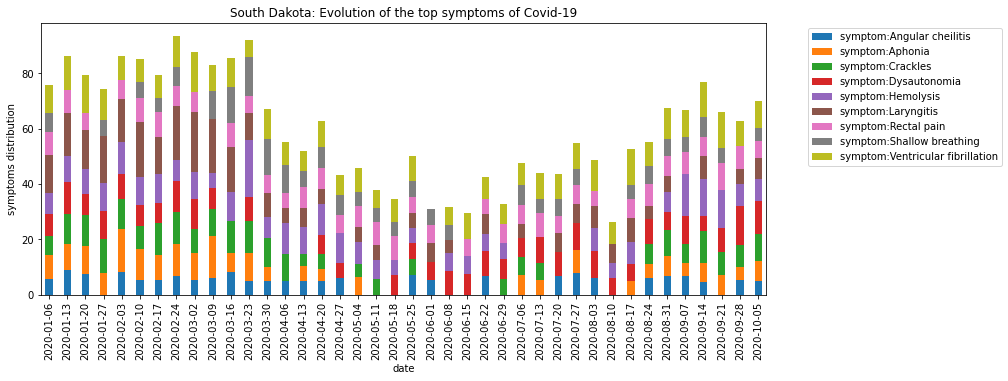

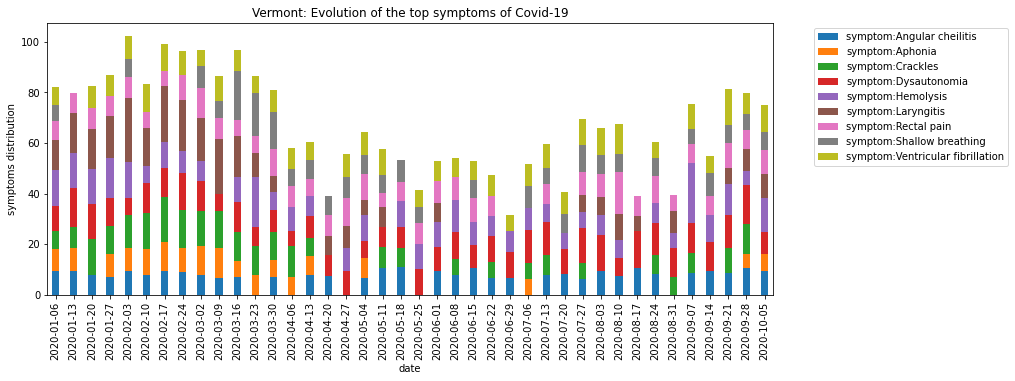

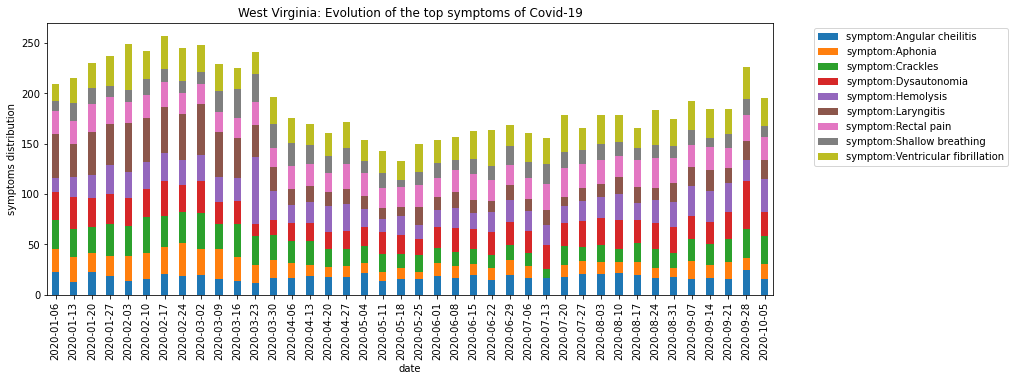

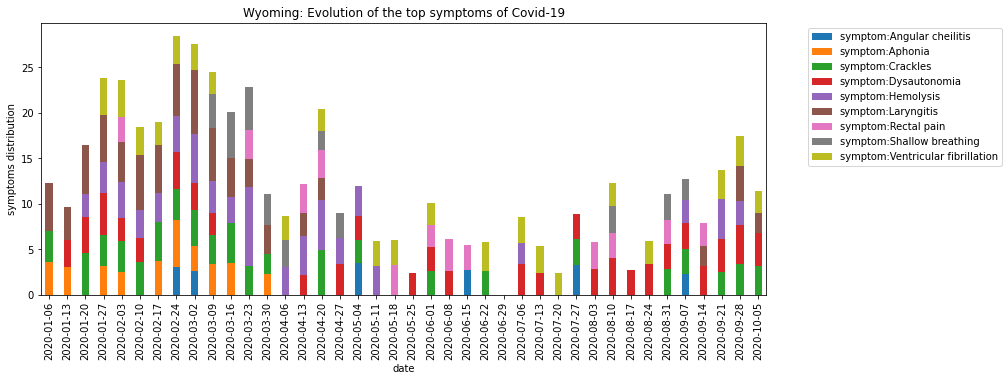

In [6]:
#task 2.1
#filter out top popular symptoms
topSympDF=columnClean(df, 420)
print(topSympDF.columns.values)

#fuction that filter by region then plot distribution graph
def plotGraph(str):
  newdf=topSympDF.loc[topSympDF['sub_region_1']==str]
  newdf=newdf.drop(['open_covid_region_code', 'country_region_code', 'country_region', 
                    'sub_region_1_code','hospitalized_cumulative', 'hospitalized_new','region_name'], axis=1)
  plotTitle=str+": Evolution of the top symptoms of Covid-19"
  plot= newdf.plot(x='date', kind="bar", stacked=True, title=plotTitle, width=0.4, figsize=(13,5))
  plot.set_ylabel("symptoms distribution")
  plot.legend(bbox_to_anchor=(1.05, 1), prop={'size': 10})
  return plot

#can be used to get df by region
#region, date, symptoms
def getSubDF(str):
  newdf=topSympDF.loc[topSympDF['sub_region_1']==str]
  newdf=newdf.drop(['open_covid_region_code', 'country_region_code', 'country_region', 
                    'sub_region_1_code','hospitalized_cumulative', 'hospitalized_new','region_name'], axis=1)
  return newdf
  
#plot distribution graph for all 16 sub regions
plotGraph("Alaska")
plotGraph("District of Columbia")
plotGraph("Delaware")
plotGraph("Hawaii")
plotGraph("Idaho")
plotGraph("Maine")
plotGraph("Montana")
plotGraph("North Dakota")
plotGraph("Nebraska")
plotGraph("New Hampshire")
plotGraph("New Mexico")
plotGraph("Rhode Island")
plotGraph("South Dakota")
plotGraph("Vermont")
plotGraph("West Virginia")
plotGraph("Wyoming")





## 2.2 Visualization of PCA

In [7]:
#task 2.2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#add mean to na data entries 
pcadf=df1.drop(['open_covid_region_code', 'country_region_code', 'country_region',
       'sub_region_1', 'sub_region_1_code'], axis=1)

pcadf = columnClean(pcadf,420)
pcadf = pcadf.pivot_table(index="date")
pcadf.reset_index()
pcadf = pcadf.fillna(pcadf.mean())

Number of features:
 before: 122 | after cleaning: 10


Text(0.5, 1.0, 'Variance Explained vs Principal Components')

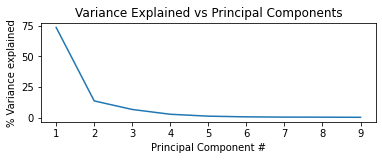

In [8]:
#we first use explained variance to determine the number of components needed
pca2 = PCA()
pca2.fit(pcadf)
num_pc_components = len(pca2.explained_variance_ratio_)
plt.subplot(2,1,1)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca2.explained_variance_ratio_)
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Variance Explained vs Principal Components")


Text(0.5, 1.0, 'Cumulative Variance Explained vs Principal Components')

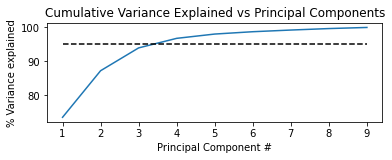

In [9]:
plt.subplot(2,1,2)
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca2.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),95*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Cumulative Variance Explained vs Principal Components")

Text(0.5, 1.0, 'PCA of top five symptoms')

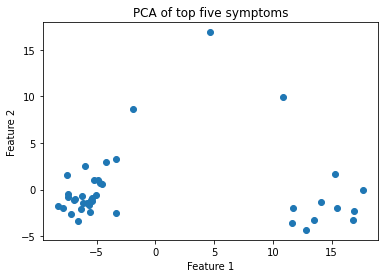

In [10]:
#pca reduction to the pca_df dataframe
pca = PCA(n_components=2)
pcadf_std=StandardScaler().fit_transform(pcadf)
pca.fit_transform(pcadf_std)
pca.fit(pcadf)
pcadf_reduced = pca.transform(pcadf)

#plot down pca graph
pcadf_plot=pd.DataFrame(pcadf_reduced)
plt.scatter(pcadf_reduced[:,0], pcadf_reduced[:,1], cmap= plt.cm.get_cmap('viridis',3))
plt.clim(-1,2.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("PCA of top five symptoms")

## 2.3 Visualization of KMeans clustering

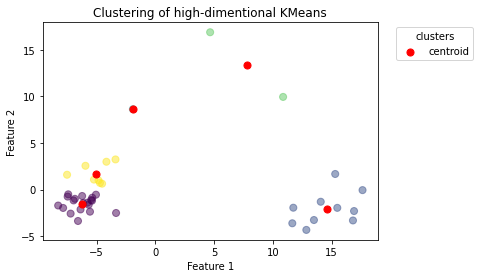

In [11]:
#task 2.3
from sklearn.cluster import KMeans

#pca reduced df
pcadf_cluster = pd.DataFrame(data=pcadf_reduced, columns= ['component1', 'component2'])
kmeans = KMeans(n_clusters=5).fit(pcadf_cluster)
centroids = kmeans.cluster_centers_
#print(centroids) 

plt.scatter(pcadf_cluster['component1'], pcadf_cluster['component2'],c= kmeans.labels_.astype(float),s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, label='centroid')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Clustering of high-dimentional KMeans")
plt.legend(bbox_to_anchor=[1.30, 1], title='clusters')
plt.show()



# TASK 3 - SUPERVISED LEARNING

In this part, you will compare two supervised learning frameworks, namely K-nearest neighbours (KNN) and decision
trees, to **predict the hospitalization cases given the search trends data**. The specific subtasks for this part include:
1. Split the data into train and validation sets using two strategies – based on regions and based on time. Specifically,
in the first case, you need to keep all data from some regions in the validation set and train on the rest (keep 80%
regions in training set and 20% in validation set, doing this multiple times to estimate cross-validation results).
In the second case, you need to keep data for the last couple of timepoints (keep data after ‘2020-08-10’) from
all regions in the validation set and train on the rest of the data
2. Compare the regression performance of KNNs and decision trees for each of the train-validation split strategies.
Note that you can report a 5-fold cross-validation performance for region-based train-validation split, wherein
you vary which regions are kept in the validation set for each fold. Please clearly report your validation error in
both cases.
3. [Optional] Explore other prediction strategies. For example, one strategy could be to learn separate models for
predicting hospitalization in each region or cluster from Task 2.

## 3.1 Feature Engineering

In [12]:
#current data
print("Original total number of subregions: ",len(df_ml.open_covid_region_code.value_counts()) )
print("Original total number of features: ",len(df_ml.columns))

# country_region_code and country region are the same for all entries
# open_covid_region_code, sub_region_1 and sub_region_1_code are duplicated , we only keep open_covid_region_code
df_ml=df_ml.drop(['country_region_code', 'country_region','sub_region_1_code','region_name'], axis=1)

# totally 624 entries 
# clean up the features with less than 60% non-null features
df_ml= columnClean(df_ml,len(df_ml)*0.6)
# claen up all the row with null entries
# df_ml.info()

# For KNN - Jing
df_knn = df_ml.copy()
df_knn = df_knn.drop(['open_covid_region_code', 'hospitalized_cumulative'], axis=1)
df_knn['date'] = pd.to_datetime(df_knn['date']) # make 'date' parseable
df_knn = df_knn.fillna(0) # Fill NaN values

# For DT - Winnie
df_ml=df_ml.dropna()
df_ml=df_ml.drop(['sub_region_1'], axis=1)

# df_knn

Original total number of subregions:  16
Original total number of features:  130
Number of features:
 before: 126 | after cleaning: 20


In [13]:
# # data normalization
# region_list=df_ml.open_covid_region_code.unique()
# for region in region_list:
#   df_tmp=df_ml.loc[df_ml['open_covid_region_code']==region]
#   for 
df_ml=df_ml.dropna()
df_ml

,open_covid_region_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,symptom:Dysautonomia,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,hospitalized_cumulative,hospitalized_new
49,US-DC,2020-03-09,-2.580226,1.796011,-0.376271,0.685830,0.294403,-0.059469,1.815680,-1.340222,-1.259067,-1.881131,2.558349,0.820812,-0.937406,1.680704,2.660000,0.0,0.0
50,US-DC,2020-03-16,-0.717163,0.847312,1.888501,0.708995,-0.997061,-0.451155,0.905608,-1.522137,-0.693345,-1.324297,3.849420,2.474539,-0.590090,-0.761061,2.242044,0.0,0.0
51,US-DC,2020-03-23,-1.272610,0.065178,2.998900,1.346038,-0.546748,1.545486,0.233685,0.786781,-0.841511,-0.731148,2.300135,1.882027,-0.922306,-0.216972,1.344668,0.0,0.0
52,US-DC,2020-03-30,0.810316,-0.709714,1.690609,3.535147,-1.566325,0.284450,-0.000213,0.506912,-0.989676,-0.380100,1.743130,0.060275,1.010587,-0.137349,0.527195,0.0,0.0
54,US-DC,2020-04-13,-0.127001,-0.818344,0.986990,-0.507177,-1.651289,-0.909714,-0.557313,-0.220747,1.205862,1.387244,0.223355,-1.266243,-1.239421,-0.761061,-0.351742,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,US-WV,2020-08-31,-0.131739,-1.070223,0.530821,-0.943827,0.308506,0.218363,-0.381903,1.550537,0.848501,-0.733917,-0.691347,-0.587750,-0.719623,0.015863,-0.729177,0.0,0.0
595,US-WV,2020-09-07,-0.621434,0.327427,-0.051598,-0.046227,-0.162248,0.767533,-0.328369,3.253187,-0.443417,0.076110,-0.000642,0.161968,1.722157,0.246283,-0.707936,0.0,0.0
596,US-WV,2020-09-14,-0.188515,-0.598652,-0.512219,-0.112874,-0.241789,0.773464,-0.127050,0.746317,-0.147636,-0.446568,-1.302931,-0.070357,-0.795572,0.363265,-0.579930,0.0,0.0
597,US-WV,2020-09-21,-0.554013,0.121115,-0.211044,0.114008,0.496808,0.639433,-0.642789,0.050091,-1.116574,0.945590,-0.244420,0.110480,1.847474,-0.308496,-0.453601,0.0,0.0


Correlation bwteen the fatures and 'hospitalized_new': 

symptom:Angular cheilitis          -0.016832
symptom:Aphonia                    -0.141354
symptom:Burning Chest Pain         -0.012433
symptom:Crackles                   -0.116472
symptom:Dysautonomia               -0.148257
symptom:Hemolysis                  -0.129082
symptom:Laryngitis                 -0.144196
symptom:Myoclonus                   0.326277
symptom:Rectal pain                 0.052797
symptom:Rumination                  0.004611
symptom:Shallow breathing          -0.145139
symptom:Stridor                    -0.185111
symptom:Urinary urgency             0.024494
symptom:Ventricular fibrillation   -0.038261
symptom:Viral pneumonia            -0.191269
hospitalized_new                    1.000000
Name: hospitalized_new, dtype: float64 



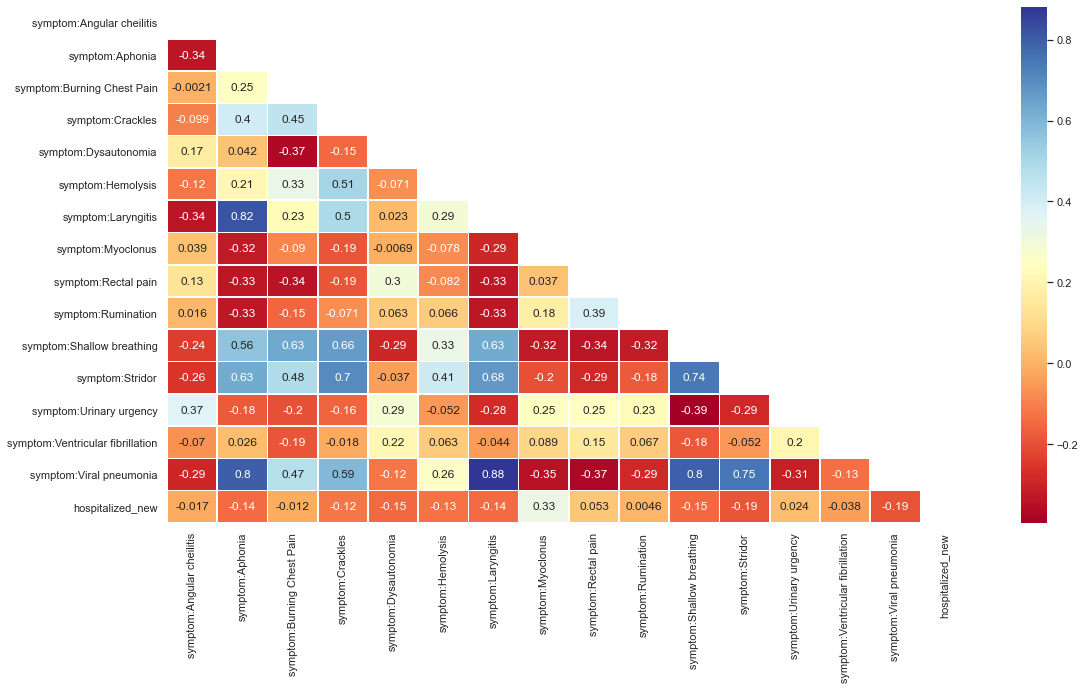

In [14]:
from sklearn import preprocessing
import seaborn as sns
# some of the features (Dtype=object) date(dtype=object-->datetime)
df_ml['new_date']=pd.to_datetime(df_ml.date)
# apply one hot encoding (or label encoding) on open_covid_region_code

# since we are trying to predict hospitalized_new
# check the correlation between all the remaining features and hospitalized_new
features=[i for i in df_ml.columns]
features.remove('date')
features.remove('open_covid_region_code')
features.remove('hospitalized_cumulative')
features.remove('new_date')
corr=df_ml[features].corr() 
# mask the upper triangle
sns.set(style="white")
plt.figure(figsize=(18,9.5))
mask=np.triu(np.ones_like(corr,dtype=np.bool))
# colour
cmap=sns.diverging_palette(240,10,n=9)
# annot to display the value
sns.heatmap(corr,annot=True,mask=mask,cmap='RdYlBu',linewidths=0.6)
print("Correlation bwteen the fatures and 'hospitalized_new': \n")
print(corr.hospitalized_new,"\n")

According to the correlation value, some of the features are not correlated to hospitalized_new (that is correlation<=0.01)
These features include: ["symptom:Rumination","symptom:Burning Chest Pain","symptom:Angular cheilitis"]

In [15]:
features_drop = ["symptom:Rumination","symptom:Burning Chest Pain","symptom:Angular cheilitis"]

# 'symptom:Myoclonus' is positively correlated with hospitalized_new 
# 'symptom:Viral pneumonia' 'symptom:Dysautonomia',
# and 'symptom:Stridor' are all negeatively correlated with hospitalized_new
# add the product of most correlated features 
df_ml['symptom:Dysautonomia*Viral pneumonia']=[df_ml['symptom:Dysautonomia'].iloc[i]*df_ml['symptom:Viral pneumonia'].iloc[i] for i in range(len(df_ml))]
df_ml['symptom:Dysautonomia*Stridor']= [df_ml['symptom:Dysautonomia'].iloc[i]*df_ml['symptom:Stridor'].iloc[i] for i in range(len(df_ml))]
df_ml['symptom:Viral pneumonia*Stridor']=[df_ml['symptom:Viral pneumonia'].iloc[i]*df_ml['symptom:Stridor'].iloc[i] for i in range(len(df_ml))]
corr=df_ml[['symptom:Dysautonomia*Viral pneumonia','symptom:Dysautonomia*Stridor','symptom:Viral pneumonia*Stridor','hospitalized_new']].corr() 
print(corr.hospitalized_new)

symptom:Dysautonomia*Viral pneumonia    0.200742
symptom:Dysautonomia*Stridor            0.214832
symptom:Viral pneumonia*Stridor        -0.096998
hospitalized_new                        1.000000
Name: hospitalized_new, dtype: float64


In [16]:
# Same as above, but for KNN

df_knn['symptom:Dysautonomia*Viral pneumonia']=[df_knn['symptom:Dysautonomia'].iloc[i]*df_knn['symptom:Viral pneumonia'].iloc[i] for i in range(len(df_knn))]
df_knn['symptom:Dysautonomia*Stridor']= [df_knn['symptom:Dysautonomia'].iloc[i]*df_knn['symptom:Stridor'].iloc[i] for i in range(len(df_knn))]
df_knn['symptom:Viral pneumonia*Stridor']=[df_knn['symptom:Viral pneumonia'].iloc[i]*df_knn['symptom:Stridor'].iloc[i] for i in range(len(df_knn))]
corr=df_knn[['symptom:Dysautonomia*Viral pneumonia','symptom:Dysautonomia*Stridor','symptom:Viral pneumonia*Stridor','hospitalized_new']].corr() 

# move hospitalized_new to the end
df_knn['hospitalized_new2'] = df_knn['hospitalized_new']
df_knn.drop(['hospitalized_new'], axis=1, inplace=True)
df_knn.rename(columns={'hospitalized_new2': 'hospitalized_new'}, inplace=True)

print(corr.hospitalized_new)
df_knn

symptom:Dysautonomia*Viral pneumonia    0.003060
symptom:Dysautonomia*Stridor           -0.038099
symptom:Viral pneumonia*Stridor        -0.101120
hospitalized_new                        1.000000
Name: hospitalized_new, dtype: float64


,sub_region_1,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,symptom:Dysautonomia,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,...,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Dysautonomia*Viral pneumonia,symptom:Dysautonomia*Stridor,symptom:Viral pneumonia*Stridor,hospitalized_new
0,Alaska,2020-01-06,0.000000,0.000000,0.000000,0.181629,0.000000,0.482254,1.002848,1.310317,...,2.306302,0.000000,0.033172,0.000000,0.605730,0.000000,0.000000,0.000000,0.000000,0.0
1,Alaska,2020-01-13,0.000000,0.000000,0.000000,0.106877,1.537845,0.000000,0.086030,0.127229,...,0.000000,0.000000,1.824442,0.489135,-0.155525,0.000000,0.000000,2.805709,0.000000,0.0
2,Alaska,2020-01-20,0.000000,0.000000,0.000000,0.147651,0.936868,0.000000,1.551790,-0.255866,...,2.466282,0.000000,1.620417,0.339936,3.792853,0.000000,0.000000,1.518118,0.000000,0.0
3,Alaska,2020-01-27,-0.396774,-0.489536,0.000000,1.581536,-0.029651,0.380019,0.091778,0.000000,...,0.450537,0.000000,1.696494,0.000000,0.000000,0.000000,-0.000000,-0.050302,0.000000,0.0
4,Alaska,2020-02-03,-0.018259,2.318433,-0.507074,1.527170,0.007523,0.000000,1.422458,2.465236,...,0.610517,0.000000,0.420473,0.000000,0.996508,-0.172280,-0.001296,0.003163,-0.072439,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,Wyoming,2020-09-07,-1.597969,0.000000,0.336648,-0.812245,-0.287631,-0.827653,0.000000,0.000000,...,-0.288337,-1.185193,-1.052618,0.000000,0.000000,0.000000,-0.000000,0.302765,-0.000000,4.0
636,Wyoming,2020-09-14,0.000000,0.000000,0.000000,0.000000,0.105387,0.000000,-1.459819,0.000000,...,1.650810,0.000000,-0.977993,-0.343062,0.000000,0.000000,0.000000,-0.103068,-0.000000,11.0
637,Wyoming,2020-09-21,0.000000,0.000000,-1.159566,-1.136374,0.718494,0.471039,0.000000,-0.736950,...,-1.467035,0.000000,-0.837036,0.000000,0.715628,0.000000,0.000000,-0.601406,-0.000000,17.0
638,Wyoming,2020-09-28,0.000000,0.000000,0.000000,0.061495,1.897547,-0.778513,-0.333574,0.000000,...,0.000000,0.000000,-0.911661,0.000000,0.999945,0.000000,0.000000,-1.729919,-0.000000,17.0


### 3.1.1 Add weather data to KNN

In [17]:
# download and load weather_data
url="https://raw.githubusercontent.com/zhiyingTan0/Applied_machine_learning/main/region_weather.csv"
#data=requests.get(url).content
df_weather=pd.read_csv(url,index_col=0)
df_weather['date']=pd.to_datetime(df_weather.date).dt.month
df_weather

def join_weather(region,month):
  df_tmp=df_weather.loc[df_weather.index==region]
  return df_tmp.loc[df_tmp.date.values==month].average_high.values[0]

#join_weather(df_ml.iloc[1].open_covid_region_code,df_ml.iloc[1].new_date.month)
df_ml['Temperature']=[join_weather(df_ml.iloc[i].open_covid_region_code,df_ml.iloc[i].new_date.month) for i in range(len(df_ml))]
corr=df_ml[['Temperature','hospitalized_new']].corr() 
print("Correlation between temperature and hospitalized_new:")
print(corr.hospitalized_new)

df_ml

Correlation between temperature and hospitalized_new:
Temperature        -0.031234
hospitalized_new    1.000000
Name: hospitalized_new, dtype: float64


,open_covid_region_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,symptom:Dysautonomia,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,...,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,hospitalized_cumulative,hospitalized_new,new_date,symptom:Dysautonomia*Viral pneumonia,symptom:Dysautonomia*Stridor,symptom:Viral pneumonia*Stridor,Temperature
49,US-DC,2020-03-09,-2.580226,1.796011,-0.376271,0.685830,0.294403,-0.059469,1.815680,-1.340222,...,-0.937406,1.680704,2.660000,0.0,0.0,2020-03-09,0.783111,0.241649,2.183361,13.3
50,US-DC,2020-03-16,-0.717163,0.847312,1.888501,0.708995,-0.997061,-0.451155,0.905608,-1.522137,...,-0.590090,-0.761061,2.242044,0.0,0.0,2020-03-16,-2.235455,-2.467266,5.548025,13.3
51,US-DC,2020-03-23,-1.272610,0.065178,2.998900,1.346038,-0.546748,1.545486,0.233685,0.786781,...,-0.922306,-0.216972,1.344668,0.0,0.0,2020-03-23,-0.735194,-1.028995,2.530701,13.3
52,US-DC,2020-03-30,0.810316,-0.709714,1.690609,3.535147,-1.566325,0.284450,-0.000213,0.506912,...,1.010587,-0.137349,0.527195,0.0,0.0,2020-03-30,-0.825758,-0.094410,0.031777,13.3
54,US-DC,2020-04-13,-0.127001,-0.818344,0.986990,-0.507177,-1.651289,-0.909714,-0.557313,-0.220747,...,-1.239421,-0.761061,-0.351742,0.0,0.0,2020-04-13,0.580829,2.090934,0.445392,19.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,US-WV,2020-08-31,-0.131739,-1.070223,0.530821,-0.943827,0.308506,0.218363,-0.381903,1.550537,...,-0.719623,0.015863,-0.729177,0.0,0.0,2020-08-31,-0.224955,-0.181324,0.428573,28.9
595,US-WV,2020-09-07,-0.621434,0.327427,-0.051598,-0.046227,-0.162248,0.767533,-0.328369,3.253187,...,1.722157,0.246283,-0.707936,0.0,0.0,2020-09-07,0.114861,-0.026279,-0.114663,25.6
596,US-WV,2020-09-14,-0.188515,-0.598652,-0.512219,-0.112874,-0.241789,0.773464,-0.127050,0.746317,...,-0.795572,0.363265,-0.579930,0.0,0.0,2020-09-14,0.140221,0.017011,0.040802,25.6
597,US-WV,2020-09-21,-0.554013,0.121115,-0.211044,0.114008,0.496808,0.639433,-0.642789,0.050091,...,1.847474,-0.308496,-0.453601,0.0,0.0,2020-09-21,-0.225353,0.054887,-0.050114,25.6




---


## 3.2 Decision Tree


*   **Best hyperparameter**




In [18]:
# find out the best hyperparameter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
from sklearn.tree import DecisionTreeRegressor

#define x and y

def best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


regressor = DecisionTreeRegressor(random_state=0,criterion="mae")

params = {
    "max_depth": randint(2, 80),
    "min_samples_leaf": randint(1,100),
    "max_leaf_nodes": randint(20,100)
        
}

search = RandomizedSearchCV(regressor, param_distributions=params, cv=5, n_jobs=1, return_train_score=True)

#cv1=df_ml.iloc[test[0]].dropna()
df_ml_clean=df_ml.dropna()
y=df_ml_clean.hospitalized_new
features_drop= features_drop+["hospitalized_new","open_covid_region_code","date","new_date","hospitalized_cumulative"]
X = df_ml_clean.drop(features_drop,axis=1)

search.fit(X, y)

best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.175 (std: 0.712)
Parameters: {'max_depth': 5, 'max_leaf_nodes': 40, 'min_samples_leaf': 53}

Model with rank: 1
Mean validation score: 0.175 (std: 0.712)
Parameters: {'max_depth': 57, 'max_leaf_nodes': 20, 'min_samples_leaf': 57}

Model with rank: 1
Mean validation score: 0.175 (std: 0.712)
Parameters: {'max_depth': 44, 'max_leaf_nodes': 40, 'min_samples_leaf': 59}

Model with rank: 1
Mean validation score: 0.175 (std: 0.712)
Parameters: {'max_depth': 47, 'max_leaf_nodes': 23, 'min_samples_leaf': 68}

Model with rank: 1
Mean validation score: 0.175 (std: 0.712)
Parameters: {'max_depth': 9, 'max_leaf_nodes': 28, 'min_samples_leaf': 66}

Model with rank: 1
Mean validation score: 0.175 (std: 0.712)
Parameters: {'max_depth': 6, 'max_leaf_nodes': 56, 'min_samples_leaf': 36}

Model with rank: 1
Mean validation score: 0.175 (std: 0.712)
Parameters: {'max_depth': 39, 'max_leaf_nodes': 62, 'min_samples_leaf': 88}

Model with rank: 1
Mean validation sc




---


### 3.2.1 Strategy1: Split the data based on region


*   **cross validation**




In [19]:
# for each subregion, keep 80% in training dataset and 20% training dataset
# apply 5 cross validation
# totally 16 regions and 39 weeks

def cross_validation(n_folds,df):
  # index include [index of each region]=[ [index of US_AK],[index of US_IT],.... ]
    index={}
    regionList=df.open_covid_region_code.unique()
    for region in regionList:
        tmp=df_ml.loc[df.open_covid_region_code==region].index
        index[region]=tmp
  # return k groups of test and train indices
    test=[]
    train=[]
    for i in range(n_folds):
        test_tmp=[]
        train_tmp=[]
        for region in index.keys():
            index_list=list(np.random.permutation(list(index.get(region))))
            
            if(len(index_list)==1):
                train_tmp=train_tmp+index_list
            else:
                threshold= int(len(index_list)*(n_folds-1)/n_folds)
                train_tmp=train_tmp+index_list[0:threshold]
                test_tmp=test_tmp+index_list[threshold:len(index_list)]
                    
        test.append(test_tmp)
        train.append(train_tmp)
    
    return test,train


test,train = cross_validation(5,df_ml)
#print(train)




*  **Model Training and prediction error**




In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
df_ml=df_ml.dropna()

def model_train(i):
  mae_local = []
  test,train = cross_validation(5,df_ml)
  print("Run ",i ,"|",end="")
  for i in range(5):
    cv_train=df_ml.loc[train[i]]
    cv_test=df_ml.loc[test[i]]
    y_train=cv_train.hospitalized_new
    X_train = cv_train.drop(features_drop,axis=1)
    
    y_test=cv_test.hospitalized_new
    X_test = cv_test.drop(features_drop,axis=1)
    
    regressor = DecisionTreeRegressor(random_state=0,criterion="mae",max_depth=25, max_leaf_nodes=80, min_samples_leaf=87)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    mae_local.append(mean_absolute_error(y_test, y_pred))
    print("{:.6f}".format(mean_absolute_error(y_test, y_pred)),end="|")
    #print((str(mean_absolute_error(y_test, y_pred)).format(1.6)),end ="|" )
    #print("MAE |CV",i,"fold| ",mean_absolute_error(y_test, y_pred),end =" " )
  print("\n")
  return np.mean(mae_local)


print(' MAE  |CV 1 fold|CV 2 fold|CV 3 fold|CV 4 fold|CV 5 fold|')
print('------------------------------------------------------------------------')
mae=[]
for i in range (10):
  mae.append(model_train(i+1))
print("average: ", np.mean(mae), np.std(mae))

 MAE  |CV 1 fold|CV 2 fold|CV 3 fold|CV 4 fold|CV 5 fold|
------------------------------------------------------------------------
Run  1 |14.105263|51.315789|23.684211|33.052632|47.052632|

Run  2 |15.894737|24.736842|47.421053|29.000000|26.421053|

Run  3 |37.000000|31.842105|44.684211|18.684211|32.947368|

Run  4 |36.263158|14.526316|48.684211|26.421053|30.947368|

Run  5 |20.947368|24.157895|22.421053|39.210526|17.736842|

Run  6 |27.157895|48.684211|44.842105|35.052632|47.000000|

Run  7 |27.789474|36.631579|31.421053|32.263158|37.000000|

Run  8 |29.894737|15.894737|42.578947|12.526316|11.105263|

Run  9 |54.368421|52.789474|35.578947|14.736842|27.105263|

Run  10 |23.947368|30.684211|40.315789|28.210526|17.000000|

average:  31.274736842105263 5.168938659899738


---


### 3.2.2 Strategy2: Split the data based on time

In [21]:
train=df_ml.loc[df_ml.date>='2020-08-10']
test=df_ml.loc[df_ml.date<'2020-08-10']
y_train=train.hospitalized_new
X_train = train.drop(features_drop,axis=1)
    
y_test=test.hospitalized_new
X_test = test.drop(features_drop,axis=1)
    
regressor = DecisionTreeRegressor(random_state=0,criterion="mae",max_depth=25, max_leaf_nodes=80, min_samples_leaf=87)


regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error| ", mae )


mean absolute error|  33.31147540983606


### 3.2.3 Add weather features
Add new feature (climate--temparature)

In [22]:
df_ml.open_covid_region_code.unique()
# download and load weather_data
url="https://raw.githubusercontent.com/zhiyingTan0/Applied_machine_learning/main/region_weather.csv"
#data=requests.get(url).content
df_weather=pd.read_csv(url,index_col=0)
df_weather['date']=pd.to_datetime(df_weather.date).dt.month
df_weather.head()

,date,average_high
open_covid_region_code,,
US-DC,3,13.3
US-DC,4,19.4
US-DC,5,23.9
US-DC,6,28.9
US-DC,7,31.7


In [23]:
def join_weather(region,month):
  df_tmp=df_weather.loc[df_weather.index==region]
  return df_tmp.loc[df_tmp.date.values==month].average_high.values[0]

#join_weather(df_ml.iloc[1].open_covid_region_code,df_ml.iloc[1].new_date.month)
df_ml['Temperature']=[join_weather(df_ml.iloc[i].open_covid_region_code,df_ml.iloc[i].new_date.month) for i in range(len(df_ml))]
corr=df_ml[['Temperature','hospitalized_new']].corr() 
print("Correlation between temperature and hospitalized_new:")
print(corr.hospitalized_new)

df_ml

Correlation between temperature and hospitalized_new:
Temperature        -0.031234
hospitalized_new    1.000000
Name: hospitalized_new, dtype: float64


,open_covid_region_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,symptom:Dysautonomia,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,...,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,hospitalized_cumulative,hospitalized_new,new_date,symptom:Dysautonomia*Viral pneumonia,symptom:Dysautonomia*Stridor,symptom:Viral pneumonia*Stridor,Temperature
49,US-DC,2020-03-09,-2.580226,1.796011,-0.376271,0.685830,0.294403,-0.059469,1.815680,-1.340222,...,-0.937406,1.680704,2.660000,0.0,0.0,2020-03-09,0.783111,0.241649,2.183361,13.3
50,US-DC,2020-03-16,-0.717163,0.847312,1.888501,0.708995,-0.997061,-0.451155,0.905608,-1.522137,...,-0.590090,-0.761061,2.242044,0.0,0.0,2020-03-16,-2.235455,-2.467266,5.548025,13.3
51,US-DC,2020-03-23,-1.272610,0.065178,2.998900,1.346038,-0.546748,1.545486,0.233685,0.786781,...,-0.922306,-0.216972,1.344668,0.0,0.0,2020-03-23,-0.735194,-1.028995,2.530701,13.3
52,US-DC,2020-03-30,0.810316,-0.709714,1.690609,3.535147,-1.566325,0.284450,-0.000213,0.506912,...,1.010587,-0.137349,0.527195,0.0,0.0,2020-03-30,-0.825758,-0.094410,0.031777,13.3
54,US-DC,2020-04-13,-0.127001,-0.818344,0.986990,-0.507177,-1.651289,-0.909714,-0.557313,-0.220747,...,-1.239421,-0.761061,-0.351742,0.0,0.0,2020-04-13,0.580829,2.090934,0.445392,19.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,US-WV,2020-08-31,-0.131739,-1.070223,0.530821,-0.943827,0.308506,0.218363,-0.381903,1.550537,...,-0.719623,0.015863,-0.729177,0.0,0.0,2020-08-31,-0.224955,-0.181324,0.428573,28.9
595,US-WV,2020-09-07,-0.621434,0.327427,-0.051598,-0.046227,-0.162248,0.767533,-0.328369,3.253187,...,1.722157,0.246283,-0.707936,0.0,0.0,2020-09-07,0.114861,-0.026279,-0.114663,25.6
596,US-WV,2020-09-14,-0.188515,-0.598652,-0.512219,-0.112874,-0.241789,0.773464,-0.127050,0.746317,...,-0.795572,0.363265,-0.579930,0.0,0.0,2020-09-14,0.140221,0.017011,0.040802,25.6
597,US-WV,2020-09-21,-0.554013,0.121115,-0.211044,0.114008,0.496808,0.639433,-0.642789,0.050091,...,1.847474,-0.308496,-0.453601,0.0,0.0,2020-09-21,-0.225353,0.054887,-0.050114,25.6


**region-based**

In [24]:
def model_train(i):
  mae_local = []
  test,train = cross_validation(5,df_ml)
  print("Run ",i ,"|",end="")
  for i in range(5):
    cv_train=df_ml.loc[train[i]]
    cv_test=df_ml.loc[test[i]]
    y_train=cv_train.hospitalized_new
    X_train = cv_train.drop(features_drop,axis=1)
    
    y_test=cv_test.hospitalized_new
    X_test = cv_test.drop(features_drop,axis=1)
    
    regressor = DecisionTreeRegressor(random_state=0,criterion="mae",max_depth=25, max_leaf_nodes=32, min_samples_leaf=68)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    mae_local.append(mean_absolute_error(y_test, y_pred))
    print("{:.6f}".format(mean_absolute_error(y_test, y_pred)),end="|")
    #print((str(mean_absolute_error(y_test, y_pred)).format(1.6)),end ="|" )
    #print("MAE |CV",i,"fold| ",mean_absolute_error(y_test, y_pred),end =" " )
  print("\n")
  return np.mean(mae_local)

print(' MAE  |CV 1 fold|CV 2 fold|CV 3 fold|CV 4 fold|CV 5 fold|')
print('------------------------------------------------------------------------')
mae=[]
for i in range (10):
  mae.append(model_train(i+1))
print("average: ", np.mean(mae), np.std(mae))

 MAE  |CV 1 fold|CV 2 fold|CV 3 fold|CV 4 fold|CV 5 fold|
------------------------------------------------------------------------
Run  1 |28.736842|36.315789|41.368421|62.263158|30.421053|

Run  2 |53.105263|25.157895|17.315789|25.842105|24.052632|

Run  3 |17.894737|33.578947|35.105263|12.157895|49.157895|

Run  4 |22.052632|21.210526|52.368421|35.157895|39.631579|

Run  5 |27.947368|42.526316|46.578947|60.526316|37.684211|

Run  6 |25.947368|17.473684|44.736842|25.526316|21.000000|

Run  7 |18.210526|41.052632|34.473684|36.526316|19.684211|

Run  8 |15.368421|16.842105|53.052632|29.789474|37.526316|

Run  9 |46.157895|12.052632|36.052632|38.105263|43.684211|

Run  10 |44.000000|29.894737|6.578947|35.842105|39.736842|

average:  32.949473684210524 4.855635101999256


**time based**

In [25]:
train=df_ml.loc[df_ml.date>='2020-08-10']
test=df_ml.loc[df_ml.date<'2020-08-10']
y_train=train.hospitalized_new
X_train = train.drop(features_drop,axis=1)
    
y_test=test.hospitalized_new
X_test = test.drop(features_drop,axis=1)
    
regressor = DecisionTreeRegressor(random_state=0,criterion="mae",max_depth=25, max_leaf_nodes=32, min_samples_leaf=68)


regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error| ", mae )

mean absolute error|  33.31147540983606


---


## 3.3 K-Nearest Neighbours



In [26]:
regions = list(df_knn['sub_region_1'].unique())
regions

['Alaska',
 'District of Columbia',
 'Delaware',
 'Hawaii',
 'Idaho',
 'Maine',
 'Montana',
 'North Dakota',
 'Nebraska',
 'New Hampshire',
 'New Mexico',
 'Rhode Island',
 'South Dakota',
 'Vermont',
 'West Virginia',
 'Wyoming']

In [27]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

'''
Perform KNN using GroupShuffleSplit, split by region
- do 5-fold cross-validation
'''
def KNN_region(df_ml, knn, toprint=False):
  groups = df_ml['sub_region_1'].values
  y = df_ml['hospitalized_new'].values # extract results (new hospitalization rates)
  X = df_ml.drop(['sub_region_1', 'hospitalized_new', 'date'], axis=1).to_numpy() # extract features (symptoms)

  maes = []
  i = 1
  for train_index, test_index in gss.split(X, y, groups):
    # print("TRAIN: ", train_index, "TEST: ", test_index)
    # print(groups[train_index], groups[test_index]) # should be distinct groups in train and test
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    # print("Accuracy:", knn.score(X_test, y_test))
    mae = mean_absolute_error(y_test, y_pred)
    if toprint:
      print("mean absolute error |CV", i, "fold| ", mae)
    maes.append(mae)
    i += 1

  return np.mean(maes)
  
'''
Perform KNN using GroupShuffleSplit, split by time (one fold)
- test => after 2020-08-10, train => rest
'''
def KNN_time(df_ml, knn):
  train = df_ml[(df_ml['date'].dt.month < 8) | (df_ml['date'].dt.month == 8) & (df_ml['date'].dt.day <= 10)]
  test = df_ml[(df_ml['date'].dt.month > 8) | (df_ml['date'].dt.month == 8) & (df_ml['date'].dt.day > 10)]
  # print(df_ml.shape[0] == test.shape[0] + train.shape[0]) # should be True

  y_train = train['hospitalized_new'].values 
  y_test = test['hospitalized_new'].values
  X_train = train.drop(['sub_region_1', 'hospitalized_new', 'date'], axis=1).to_numpy()
  X_test = test.drop(['sub_region_1', 'hospitalized_new', 'date'], axis=1).to_numpy()

  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  # print("Accuracy:", knn.score(X_test, y_test))
  return mean_absolute_error(y_test, y_pred), X_train, y_train, X_test, y_test

n_neighbors_time : 2
n_neighbors_region : 7


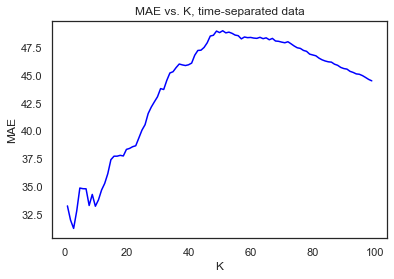

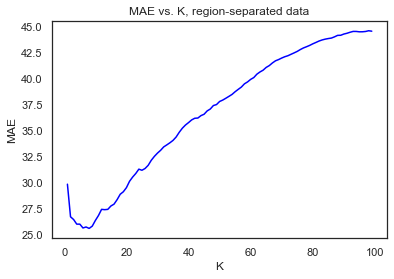

In [28]:
gss = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=69)

maes = []
for i in range(1, 100):
  knn = KNeighborsRegressor(n_neighbors=i)
  mae, _, _, _, _ = KNN_time(df_knn, knn)
  maes.append(mae)

plt.figure()
plt.plot(range(1, 100), maes, color='blue')
plt.title('MAE vs. K, time-separated data')
plt.xlabel('K')
plt.ylabel('MAE')

n_neighbors_time = np.argmin(maes)
print('n_neighbors_time :', n_neighbors_time)

maes = []
for i in range(1, 100):
  knn = KNeighborsRegressor(n_neighbors=i)
  maes.append(KNN_region(df_knn, knn))

plt.figure()
plt.plot(range(1, 100), maes, color='blue')
plt.title('MAE vs. K, region-separated data')
plt.xlabel('K')
plt.ylabel('MAE')

n_neighbors_region = np.argmin(maes)
print('n_neighbors_region :', n_neighbors_region)

In [29]:
knn_region = KNeighborsRegressor(n_neighbors=n_neighbors_region)
knn_time = KNeighborsRegressor(n_neighbors=n_neighbors_time)


knns1 = []
knns2 = []
for i in range(10):
  knns1.append(KNN_region(df_knn, knn_region))
  MAE_time, _, _, _, _ = KNN_time(df_knn, knn_time)
  knns2.append(MAE_time)

print("MEAN MAE REGION", np.mean(knns1))
print("STD MAE REGION", np.std(knns1))
print("MEAN MAE TIME", np.mean(knns2))
print("STD MAE TIME", np.std(knns2))

MEAN MAE REGION 25.75517857142857
STD MAE REGION 0.0
MEAN MAE TIME 32.046875
STD MAE TIME 0.0
